In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

-3.3941552158071526 10.502704166330552


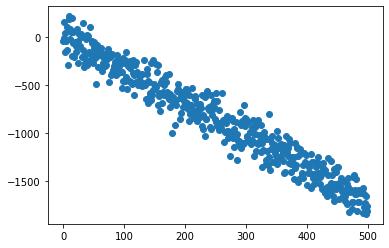

In [2]:
max_x = 500
slope_range = [.1, 10]
slope_direction = np.random.choice([-1,1])
intercept_range = [-40, 40]
residual_var = 100
X = torch.from_numpy(np.arange(max_x))
X = X.type(torch.float64)
m = np.random.uniform(*slope_range) * slope_direction
b = np.random.uniform(*intercept_range)
y = m * X + b + np.random.normal(0, residual_var, len(X)) * m/3
print(m, b)
plt.scatter(X, y)

In [3]:
class Model:
    def __init__(self, params):
        self.parameters = params # weights for slope and bias (could have been stored outside of model)
        self.y_pred = None # Will hold last prediction when training loop is done
    def set_learning_objects(self, criterion, optimizer):
        self.criterion = criterion
        self.optimizer = optimizer
    def train(self, X):
        return self.parameters[0][0] * X + self.parameters[0][1] # Just a simple line eq. with current m and b weights
    def training_loop(self, epochs, X, y):
        for epoch in [e+1 for e in range(epochs)]: # Make ephochs 1 based
            self.y_pred = self.train(X) # No batching here, we run all data and adjust the weights after the run
            loss = self.criterion(self.y_pred, y) # What ever loss function that was passed is used
            self.optimizer.zero_grad() # Gradients sum with each back prop, so we need to manually zero out the last derivatives
            loss.backward() # The acutal back proagation
            self.optimizer.step() # Updates the weights (self.parameters)
            if epoch % 10 == 0 or epoch == np.max(range(epochs)):
                print("Epoch: {} - Loss: {}".format(epoch, float(loss)))

In [4]:
weights = np.random.normal(.7, .01) #No specal sauce here, but we don't want to start at the extreams (too near 0 or 1)
weights

0.6949640695870611

In [5]:
bias = np.random.normal(0, .01) #No specal sauce here, but we don't want to start at the extreams (too near 0 or 1)
bias

-0.015363004956456585

In [6]:
#weights are a enumerable tensor.  In our simple r1 maps to r1, it is just 2 trainable paramaters
weights_bias = torch.tensor([weights, bias], requires_grad=True) # requires_grad=True maintains the state for the back prop

In [7]:
#custom optimizer, just plain old Gradiant Decent with a learning rate
class GD_Optimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-3):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr)
        super(GD_Optimizer, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data

                p.data.add_(-group['lr'], d_p)

        return loss            

In [8]:
model = Model([weights_bias])

#hyper-parameters
epochs = 500
learning_rate = 1e-3

#loss
# criterion = torch.nn.MSELoss()
# criterion = torch.nn.SmoothL1Loss()
# criterion = torch.nn.L1Loss()
# criterion = lambda y, y_pred : torch.mean((y - y_pred)**2)
criterion = lambda y, y_pred : torch.mean(abs(y - y_pred))

# back prop gradient decent optimizer
# optimizer = optim.SGD(model.parameters, lr=learning_rate)
# optimizer = optim.SGD(model.parameters, lr=learning_rate, momentum=0.9)
# optimizer = optim.Adam(model.parameters)
optimizer = GD_Optimizer(model.parameters, lr=learning_rate)


model.set_learning_objects(criterion, optimizer)

In [9]:
y_pred = model.train(X)
model.parameters
#This is just a made up linear plot with random slope and intercept since no parameter training was done
# plt.scatter(y, y_pred) 

[tensor([ 0.6950, -0.0154], requires_grad=True)]

In [10]:
criterion(y, y_pred)

tensor(1024.0057, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [11]:
model.training_loop(epochs, X, y)

Epoch: 10 - Loss: 470.51520062318747
Epoch: 20 - Loss: 95.08470391447233
Epoch: 30 - Loss: 94.92727650047573
Epoch: 40 - Loss: 94.92742892132433
Epoch: 50 - Loss: 94.9288262239331
Epoch: 60 - Loss: 94.92717258067532
Epoch: 70 - Loss: 94.9271640542756
Epoch: 80 - Loss: 94.9268145855303
Epoch: 90 - Loss: 94.92803851248058
Epoch: 100 - Loss: 94.92865941228807
Epoch: 110 - Loss: 94.92685091314522
Epoch: 120 - Loss: 94.92752645150675
Epoch: 130 - Loss: 94.92717698276147
Epoch: 140 - Loss: 94.92682751401617
Epoch: 150 - Loss: 94.92787967563899
Epoch: 160 - Loss: 94.92874620714127
Epoch: 170 - Loss: 94.92678098639205
Epoch: 180 - Loss: 94.92801835299763
Epoch: 190 - Loss: 94.92861909332215
Epoch: 200 - Loss: 94.9268240338346
Epoch: 210 - Loss: 94.92749285236849
Epoch: 220 - Loss: 94.9271433836232
Epoch: 230 - Loss: 94.9267939148779
Epoch: 240 - Loss: 94.92785951615603
Epoch: 250 - Loss: 94.92870588817536
Epoch: 260 - Loss: 94.92674738725378
Epoch: 270 - Loss: 94.92799819351467
Epoch: 280 - Lo

In [12]:
model.parameters
pred_slope = model.parameters[0][0].item()
pred_intercept = model.parameters[0][1].item()
print ("Actual Slope: {}  Actual Intercept: {}".format(m, b))
print ("Model Slope: {}  Model Intercept: {}".format(pred_slope, pred_intercept))

Actual Slope: -3.3941552158071526  Actual Intercept: 10.502704166330552
Model Slope: -3.3965718746185303  Model Intercept: -0.021043237298727036


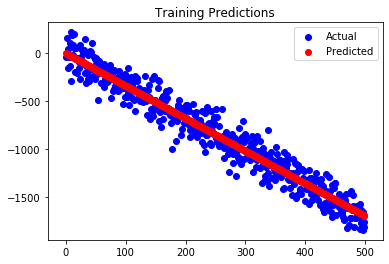

In [13]:
plt.scatter(X, y, color='b', label='Actual')
plt.scatter(X, model.y_pred.detach().numpy(), color='r', label='Predicted')
plt.title('Training Predictions')
plt.legend()
plt.show()